# Kalman Filter-Based UAV Localizationusing RF Sensing
his project constitutes a segment of a graduate-level course in Statistical Signal Processing. Its focal point is the application of an Extended Kalman Filter (EKF) for trajectory tracking and localization of an Unmanned Aerial Vehicle (UAV). The EKF is specifically tailored to estimate the UAV's trajectory during intervals of constant velocity, constant acceleration, and constant turns, encompassing kinematic motion models. By extending conventional linear Kalman filtering techniques, the EKF model demonstrates adaptability to variations in the UAV's motion. The primary objective of this project was to enhance both the accuracy and output, building upon the foundations laid in reference [1].

Reference:
[1] - U. Bhattacherjee, E. Ozturk, O. Ozdemir, I. Guvenc, M. L. Sichitiu, and H. Dai, “Experimental study of outdoor UAV localization and tracking using passive RF sensing,” in Proceedings of the 15th ACM Workshop on Wireless Network Testbeds, Experimental Evaluation & Characterization, pp. 31–38, 2022.

Data preprocessing was conducted using MATLAB to leverage its robust geographic processing libraries. The preprocessing steps encompassed timestamp alignment, removal of erroneous values, and conversion of geographical coordinates to local Cartesian coordinates. This processing methodology closely adhered to the outlined procedures in [1].

## Import Libraries

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Import Data

In [44]:
df = pd.read_csv('sensor_prep.csv')  
df_uav = pd.read_csv('uav_prep.csv') 

## Auxilary Functions
Based on the implementation of EKF based tracking as completed in [1].

Following the approach for segmentation in [1], we plotted the dataset in Cartesian coordinate and manually labeled segments as one of three kinematic motion models: 

    1. CV - constant velocity
    2. CA - constant acelleration
    3. CT - constant trajectory

In [45]:
# Constant trajectory state transition matrix.
def f_ct(s_prv, T):
    x, y, vx, vy, omg = s_prv[0], s_prv[1], s_prv[2], s_prv[3], s_prv[4]
    s = np.zeros(5)
    s[0] = x + vx/omg * np.sin(omg*T) - vy/omg * (1 - np.cos(omg*T))
    s[1] = vx * np.cos(omg*T) - vy * np.sin(omg*T)
    s[2] = y + vx/omg * (1 - np.cos(omg*T)) + vy/omg *  np.sin(omg*T)
    s[3] = vx * np.sin(omg*T) + vy * np.cos(omg*T)
    s[4] = omg

    return s

In [46]:
# Gradient of the CT state transition matrix. 
def grad_f_ct(s,T):
    vx = s[2]
    vy = s[3]
    w = s[4]
    F = np.array([[1, 0,   np.sin(w*T)/w,  -(1-np.cos(w*T))/w,  (-np.sin(w*T)*(T*w*vy+vx)+np.cos(w*T)*(T*w*vx-vy)+vy)/w**2 ],
                  [0, 0,    np.cos(w*T),      -np.sin(w*T),               -T*(vx*np.sin(w*T)+vy*np.cos(w*T))               ],
                  [0, 1, (1-np.cos(w*T))/w,   np.sin(w*T)/w,    (np.sin(w*T)*(T*w*vx-vy)+np.cos(w*T)*(T*w*vy-vx)-vx)/w**2  ],
                  [0, 0,    np.sin(w*T),      np.cos(w*T),                 T*(vx*np.cos(w*T)-vy*np.sin(w*T))               ],
                  [0, 0,         0,                0,                                        1                             ]])

    return F

In [47]:
# Constant acceleration state transition matrix.
def transition_mat_ca(T):
    F = np.array([[1, 0, T,    0,    T**2/2,     0    ],
                    [0, 1,  0,   T,      0,      T**2/2 ],
                    [0, 0,  1,   0,      T,        0    ],
                    [0, 0,  0,   1,      0,        T    ],
                    [0, 0,  0,   0,      1,        0    ],
                    [0, 0,  0,   0,      0,        1    ]])
    return F

In [48]:
# CV model covariance matrix. 
def noise_cov_mat_cv(s2x, s2y, T):
    q1 = T
    q2 = T**2 / 2
    q3 = T**3 / 3
    Q = np.array([[s2x*q3, 0,   s2x*q2,  0   ],
                  [  0,  s2y*q3,  0,   s2y*q2],
                  [s2x*q2, 0,   s2x*q1,  0   ],
                  [  0,  s2y*q2,  0,   s2y*q1]])
    return Q

In [49]:
# CA model covariance matrix. 
def noise_cov_mat_ca(s2x, s2y, T):
    q1 = T
    q2 = T**2 / 2
    q3 = T**3 / 6
    q4 = T**4 / 8
    q5 = T**5 / 20
    Q = np.array([[s2x*q5, 0,  s2x*q4, 0,  s2x*q3, 0   ],
                  [  0,  s2y*q5, 0,  s2y*q4, 0,  s2y*q3],
                  [s2x*q4, 0,  s2x*q3, 0,  s2x*q2, 0   ],
                  [  0,  s2y*q4, 0,  s2y*q3, 0,  s2y*q2],
                  [s2x*q3, 0,  s2x*q2, 0,  s2x*q1, 0   ],
                  [  0,  s2y*q3, 0,  s2y*q2, 0,  s2y*q1]])
    return Q

In [50]:
# CT model covariance matrix. 
def noise_cov_mat_ct(s2x, s2y, T):
    q1 = T
    q2 = T**2 / 2
    q3 = T**3 / 6
    Q = np.array([[s2x*q3,  0,   s2x*q2, 0,      0   ],
                  [  0,   s2y*q3,  0,   s2y*q2,  0   ],
                  [s2x*q2,  0,   s2x*q1,  0,     0   ],
                  [  0,   s2y*q2,  0,  s2y*q1,   0   ],
                  [  0,     0,     0,    0,   s2x*q1]])
    return Q

## Implement the EKF

In [51]:
sigma2_x = df["x"].std()/4
sigma2_y = df["y"].std()/8
z = df.to_numpy() 
z = z[:,0:2] # observations
n = len(z)

Create time interevals between all data points.

In [52]:
T = df['time'].to_numpy() 
T = T[1:]

Manually label all intervals between datapoints. This was completed by observing a 2D plot of the UAV path, and selecting segments that matched each of the three motion models. 

In [53]:
labels = np.zeros(len(z)) # segmentation, CV = '0', CA = '1', CT = '2'
labels[16:28] = 1
labels[38:46] = 1
labels[54:58] = 1
labels[100:140] = 2
labels[141:201] = 1
labels[260:264] = 1

In [54]:
# initialization 
s = np.zeros((6,n))
P = np.zeros((n,6,6))


In [55]:
for k, (x,y) in enumerate(z[1:]):
    if labels[k+1] == 0: # CV motion model
        s_prv = s[0:4,k] # need to use only the 4 first elements of the previous state
        P_prv = P[k,0:4,0:4]
        F = np.array([[1, 0, T[k], 0  ],
                    [0, 1,  0,  T[k]],
                    [0, 0,  1,   0  ],
                    [0, 0,  0,   1  ]])
        
        H = np.array([[1, 0, 0, 0 ],
                    [0, 1, 0, 0 ]])

        
        Q = noise_cov_mat_cv(sigma2_x, sigma2_y, T[k])
    
    elif labels[k+1] == 1: # CA motion model
        if len(s[:,k]) == 6:
            s_prv = s[:,k] # previous state came from a same MM
            P_prv = P[k,:,:]
        else:
            s_prv = np.zeros(6)
            P_prv = np.zeros((6,6)) ######## should it be zero in all other elemetns?????
            s_prv[0:4] = s[0:4,k] # keep only the common elements - previous state came from a different MM
            P_prv[0:4,0:4] = P[k,0:4,0:4]
            
        F = transition_mat_ca(T[k])

        H = np.array([[1, 0, 0, 0, 0, 0],
                    [0, 1, 0, 0, 0, 0]])

        Q = noise_cov_mat_ca(sigma2_x, sigma2_y, T[k])

    
    else: # CT motion model
        if len(s[:,k]) == 5:
            s_prv = s[:,k] # previous state came from a same MM
            P_prv = P[k,:,:]
        else:
            s_prv = np.zeros(5)
            P_prv = np.zeros((5,5)) ######## should it be zero in all other elemetns?????
            s_prv[0:4] = s[0:4,k] # keep only the common elements - previous state came from a different MM
            s_prv[4] = np.sqrt(s_prv[2]**2 + s_prv[3]**2)
            P_prv[0:4,0:4] = P[k,0:4,0:4]

        H = np.array([[1, 0, 0, 0, 0],
                        [0, 1, 0, 0, 0]])

        Q = noise_cov_mat_ct(sigma2_x, sigma2_y, T[k])

    
    # Prediction step
    if labels[k+1] == 2: # for CT the model is not linear
        s_pred = f_ct(s_prv, T[k])
        F = grad_f_ct(s_pred, T[k])
    else: # for CV and CA it is a linear model
        s_pred = F @ s_prv
    
    P_pred = F @ P_prv @ F.T + Q

    # Update step
    d = len(s_pred)
    R = np.diag([sigma2_x,sigma2_y])

    K = P_pred @ H.T @ np.linalg.inv(H @ P_pred @ H.T + R)
    s[:len(s_pred),k+1] = s_pred + K @ (z[k] - H @ s_pred)
    P[k+1,0:d,0:d] = (np.eye(d) - K @ H)

In [56]:
np.save('state_estimate_1', s)
xy_true = df_uav.to_numpy()
xy_true = xy_true[:,0:2]
xy_pred = s[0:2,:]*1.4
xy_sen = df.to_numpy()
xy_sen = xy_sen[:,0:2]
print(f"Overall accuracy (meters): {np.sqrt(((xy_true-xy_pred.T)**2).sum())/n :.4f}")
indices = (labels == 0)
print(f"CV accuracy (meters): {np.sqrt(((xy_true[indices,:]-xy_pred.T[indices,:])**2).sum())/indices.sum() :.4f}")
indices = (labels == 1)
print(f"CA accuracy (meters): {np.sqrt(((xy_true[indices,:]-xy_pred.T[indices,:])**2).sum())/indices.sum() :.4f}")
indices = (labels == 2)
print(f"CT accuracy (meters): {np.sqrt(((xy_true[indices,:]-xy_pred.T[indices,:])**2).sum())/indices.sum() :.4f}")

Overall accuracy (meters): 3.4558
CV accuracy (meters): 4.7632
CA accuracy (meters): 6.8917
CT accuracy (meters): 4.6889


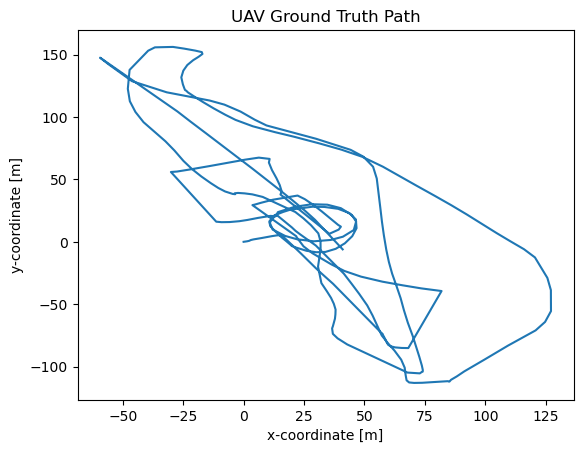

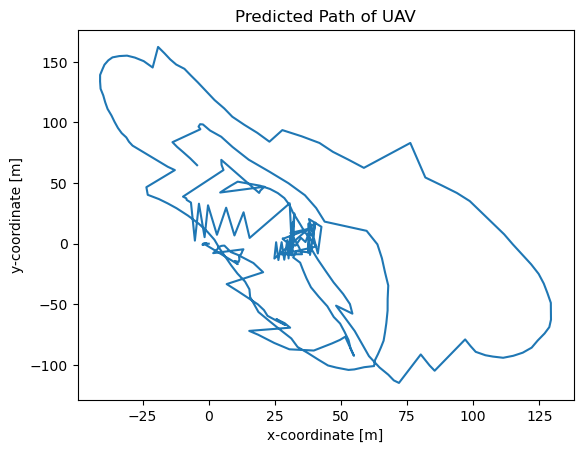

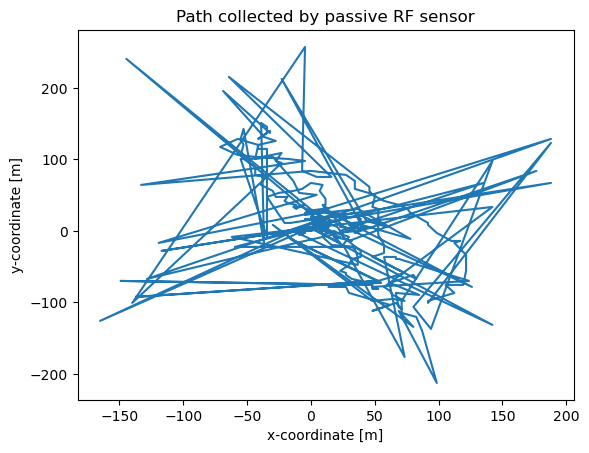

In [58]:
fig1, ax1 = plt.subplots()
ax1.plot(xy_true[:,0],xy_true[:,1])
ax1.set_title("UAV Ground Truth Path")
ax1.set_xlabel('x-coordinate [m]')
ax1.set_ylabel('y-coordinate [m]')
fig2, ax2 = plt.subplots()
ax2.plot(xy_pred[0,:],xy_pred[1,:])
ax2.set_title("Predicted Path of UAV")
ax2.set_xlabel('x-coordinate [m]')
ax2.set_ylabel('y-coordinate [m]')
fig3, ax3 = plt.subplots()
ax3.plot(xy_sen[:,0],xy_sen[:,1])
ax3.set_title("Path from Collected RF Sensor Values")
ax3.set_xlabel('x-coordinate [m]')
ax3.set_ylabel('y-coordinate [m]')
plt.show()
